In [1]:
from cryptography.hazmat.primitives.asymmetric import rsa
import cryptography.hazmat.primitives.serialization as serialization

def cryptography(key_size=2048, amount = 1):
    for _ in range(amount):
        key = rsa.generate_private_key(public_exponent=65537, key_size=key_size)
        public_key = key.public_key().public_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PublicFormat.SubjectPublicKeyInfo
        ).decode('utf-8')
        private_key = key.private_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PrivateFormat.TraditionalOpenSSL,
            encryption_algorithm=serialization.NoEncryption()
        ).decode('utf-8')

In [2]:
from Crypto.PublicKey import RSA as crypto_rsa

def pycryptodome(key_size=2048, amount=1):
    for _ in range(amount):
        key = crypto_rsa.generate(key_size)
        private_key = key.export_key().decode('utf-8')
        public_key = key.publickey().export_key().decode('utf-8')

In [3]:
import paramiko
import io

def paramiko_rsa(key_size=2048, amount=1):
    for _ in range(amount):
        key = paramiko.RSAKey.generate(key_size)
        private_key_io = io.StringIO()
        key.write_private_key(private_key_io)
        private_key = private_key_io.getvalue()
        public_key = f"{key.get_name()} {key.get_base64()}"

In [4]:
import subprocess
import os

def generate_rsa_keys_openssl_iterative(key_size=2048, amount=2):
    private_key_file = "private_key.pem"
    public_key_file = "public_key.pem"
    for _ in range(amount):
        subprocess.run(["openssl", "genpkey", "-algorithm", "RSA", "-out", private_key_file, "-pkeyopt", f"rsa_keygen_bits:{key_size}"], stdout=subprocess.DEVNULL, check=True)
        subprocess.run(["openssl", "rsa", "-pubout", "-in", private_key_file, "-out", public_key_file], stdout=subprocess.DEVNULL, check=True)

        with open(private_key_file, "r") as priv_file:
            private_key = priv_file.read()

        with open(public_key_file, "r") as pub_file:
            public_key = pub_file.read()

    os.remove(private_key_file)
    os.remove(public_key_file)
    return public_key, private_key


In [5]:
import subprocess
import os

def generate_rsa_keys_openssl_burst(key_size=2048, amount=2):
    # Call the bash script to generate the keys
    subprocess.run(["./openssl.sh", str(amount), str(key_size)], check=True, stdout=subprocess.DEVNULL)
    
    for i in range(1, amount + 1):
        private_key_file = f"private_key_{i}.pem"
        public_key_file = f"public_key_{i}.pem"

        with open(private_key_file, "r") as priv_file:
            private_key = priv_file.read()

        with open(public_key_file, "r") as pub_file:
            public_key = pub_file.read()

        # Optionally delete the key files after reading them
        os.remove(private_key_file)
        os.remove(public_key_file)



In [6]:
import subprocess
import os

def generate_rsa_keys_ssh_iterative(key_size=2048, amount=2):
    private_key_file = "private_key.pem"
    public_key_file = private_key_file + ".pub"
    for _ in range(amount):
        subprocess.run(["ssh-keygen", "-t", "rsa", "-b", str(key_size), "-f", private_key_file, "-N", ""], stdout=subprocess.DEVNULL, check=True)

        with open(private_key_file, "r") as priv_file:
            private_key = priv_file.read()

        with open(public_key_file, "r") as pub_file:
            public_key = pub_file.read()


        os.remove(private_key_file)
        os.remove(public_key_file)




In [7]:
import os

def generate_rsa_keys_ssh_burst(key_size=2048, amount=2):
    # Call the bash script to generate the keys
    subprocess.run(["./ssh-keygen.sh", str(amount), str(key_size)], check=True, stdout=subprocess.DEVNULL)
    for i in range(1, amount + 1):
        private_key_file = f"key_{i}"
        public_key_file = f"key_{i}.pub"

        with open(private_key_file, "r") as priv_file:
            private_key = priv_file.read()

        with open(public_key_file, "r") as pub_file:
            public_key = pub_file.read()

        # Optionally delete the key files after reading them
        os.remove(private_key_file)
        os.remove(public_key_file)





In [8]:
import time
from tqdm import tqdm

gen_list = [
    ("cryptography", cryptography),
    ("pycryptodome", pycryptodome),
    ("paramiko", paramiko_rsa),
    ("openssl_iterative", generate_rsa_keys_openssl_iterative),
    ("openssl_burst", generate_rsa_keys_openssl_burst),
    ("ssh_iterative", generate_rsa_keys_ssh_iterative),
    ("ssh_burst", generate_rsa_keys_ssh_burst)
]

def benchmark(key_size, max_amount=10):
    times = {name: [] for name, _ in gen_list}
    for amount in tqdm(range(1, max_amount + 1)):
        for name, func in gen_list:
            start = time.time()
            func(key_size, amount)
            end = time.time()
            times[name].append(end - start)
    return times

data = benchmark(1024, 100)

  0%|          | 0/100 [00:00<?, ?it/s]...............+++++
.....................................+++++
writing RSA key
...........+++++
...+++++
writing RSA key
  1%|          | 1/100 [00:00<00:32,  3.01it/s].........+++++
.................+++++
writing RSA key
.............................+++++
.................................................................+++++
writing RSA key
.............................................................+++++
................+++++
writing RSA key
..........+++++
..............+++++
writing RSA key
  2%|▏         | 2/100 [00:00<00:41,  2.36it/s].....+++++
.....................+++++
writing RSA key
..............................+++++
..........+++++
writing RSA key
.............................................................+++++
..................................................................................................+++++
writing RSA key
.......+++++
.............+++++
writing RSA key
.........+++++
......................+++++
writing RSA 

In [9]:
import json
with open("data.json", "w") as f:
    json.dump(data, f, indent=4)
    
with open("data.json", "r") as f:
    data = json.load(f)

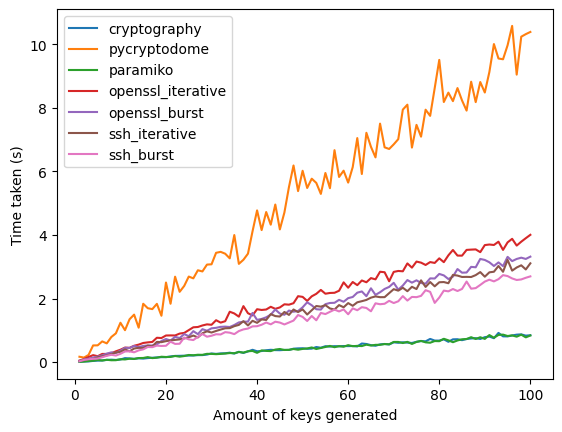

In [10]:
import matplotlib.pyplot as plt
def benchmark_plot():
    times = data
    for name, values in times.items():
        plt.plot(range(1, len(values) + 1), values, label=name)
    plt.xlabel("Amount of keys generated")
    plt.ylabel("Time taken (s)")
    plt.legend()
    plt.show()
    
benchmark_plot()